## 1️ Setup & Installation

In [12]:
# Install required packages (run this first in Google Colab)
!pip install -q diffusers transformers accelerate torch torchvision matplotlib

In [13]:
# Import necessary libraries
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
import matplotlib.pyplot as plt
import os

# For reproducibility
import random
import numpy as np

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

print(" Imports successful!")

 Imports successful!


In [14]:
# Check GPU availability
if torch.cuda.is_available():
    device = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    print(f" GPU Available: {gpu_name}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = "cpu"
    print(" No GPU detected. This will be VERY slow. Enable GPU in Runtime > Change runtime type.")

 GPU Available: Tesla T4
   VRAM: 15.83 GB


In [15]:
# Create output directory
os.makedirs("../outputs", exist_ok=True)
print(" Output directory ready")

 Output directory ready


---

## 2️ Load Pre-trained Stable Diffusion Model

We'll use **Stable Diffusion 1.5** from Hugging Face:
- Well-documented and widely used
- Fast inference (~5-10 seconds per image)

In [16]:
# Model ID from Hugging Face Hub
model_id = "runwayml/stable-diffusion-v1-5"

print("Loading Stable Diffusion 1.5...")
print("This may take 2-3 minutes on first run (downloading ~5GB model)\n")

# Load the pipeline with memory optimizations
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # Use FP16 for memory efficiency (half precision)
    safety_checker=None,  # Disable safety checker for educational purposes
)

# Move to GPU
pipe = pipe.to(device)

# Enable memory-efficient attention (reduces VRAM usage)
pipe.enable_attention_slicing()

# Use faster scheduler (DPM-Solver++ is 2x faster than default)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

print(" Model loaded successfully!")
print(f"   Components: {list(pipe.components.keys())}")
print("   ├─ text_encoder: CLIP for encoding prompts")
print("   ├─ unet: Denoising network (the 'brain')")
print("   ├─ vae: Variational autoencoder (latent ↔ pixel space)")
print("   └─ scheduler: Controls the denoising timesteps")

Loading Stable Diffusion 1.5...
This may take 2-3 minutes on first run (downloading ~5GB model)



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its resul

 Model loaded successfully!
   Components: ['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']
   ├─ text_encoder: CLIP for encoding prompts
   ├─ unet: Denoising network (the 'brain')
   ├─ vae: Variational autoencoder (latent ↔ pixel space)
   └─ scheduler: Controls the denoising timesteps


###  Why These Optimizations?

| Optimization | Purpose | Memory Saved |
|--------------|---------|-------------|
| `torch.float16` | Use 16-bit floats instead of 32-bit | ~50% |
| `enable_attention_slicing()` | Process attention in chunks | ~30% |
| `DPMSolverMultistepScheduler` | Faster sampling (quality preserved) | Speeds up 2x |

---

## 3️ Generate Your First Image!

Let's create a simple helper function and generate images.

In [17]:
def generate_image(prompt, num_inference_steps=25, guidance_scale=7.5, seed=None):
    """
    Generate an image from a text prompt.

    Args:
        prompt (str): Text description of desired image
        num_inference_steps (int): Number of denoising steps (more = higher quality but slower)
        guidance_scale (float): How strongly to follow the prompt (higher = more literal)
        seed (int): Random seed for reproducibility

    Returns:
        PIL.Image: Generated image
    """
    if seed is not None:
        set_seed(seed)

    # Generate!
    with torch.autocast(device):
        result = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
        )

    return result.images[0]

print(" Generation function ready!")

 Generation function ready!


Generating: 'a photo of a cat wearing a wizard hat, studio lighting, high quality'


  0%|          | 0/25 [00:00<?, ?it/s]

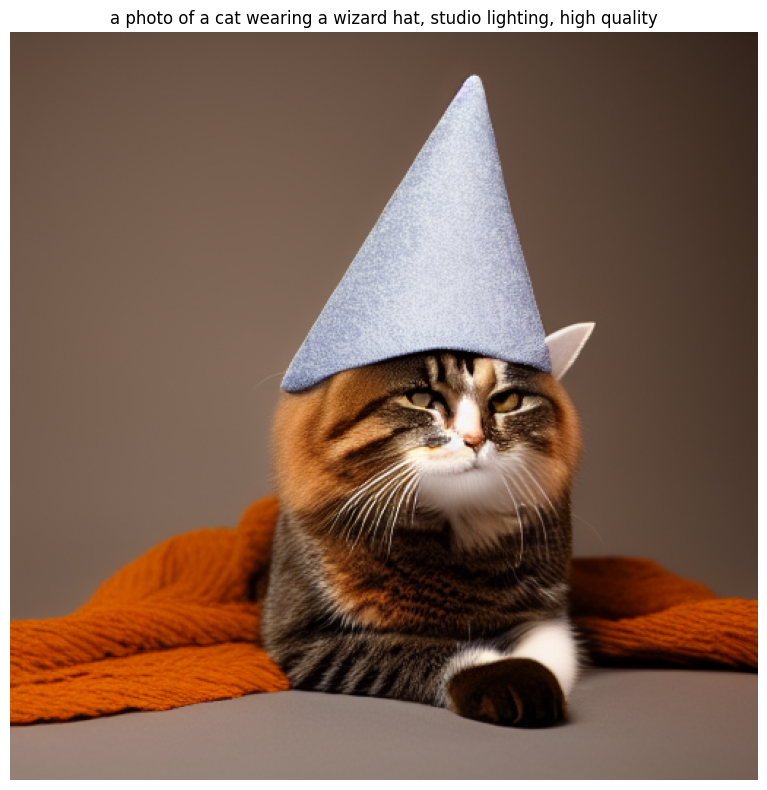

 Saved to outputs/01_cat_wizard.png


In [18]:
# Example 1: Simple prompt
prompt = "a photo of a cat wearing a wizard hat, studio lighting, high quality"

print(f"Generating: '{prompt}'")
image = generate_image(prompt, seed=42)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title(prompt, fontsize=12, wrap=True)
plt.tight_layout()
plt.show()

# Save
image.save("../outputs/01_cat_wizard.png")
print(" Saved to outputs/01_cat_wizard.png")

---

## 4️ Exploring Generation Parameters

Let's see how different parameters affect the output.

### Parameter 1: `guidance_scale` (Prompt Adherence)

Controls **how literally** the model follows your prompt:
- **Low (1-5)**: More creative, less predictable
- **Medium (7-10)**: Balanced (default: 7.5)
- **High (15+)**: Very literal, can be over-saturated

Generating with guidance_scale=3.0...


  0%|          | 0/25 [00:00<?, ?it/s]

Generating with guidance_scale=7.5...


  0%|          | 0/25 [00:00<?, ?it/s]

Generating with guidance_scale=15.0...


  0%|          | 0/25 [00:00<?, ?it/s]

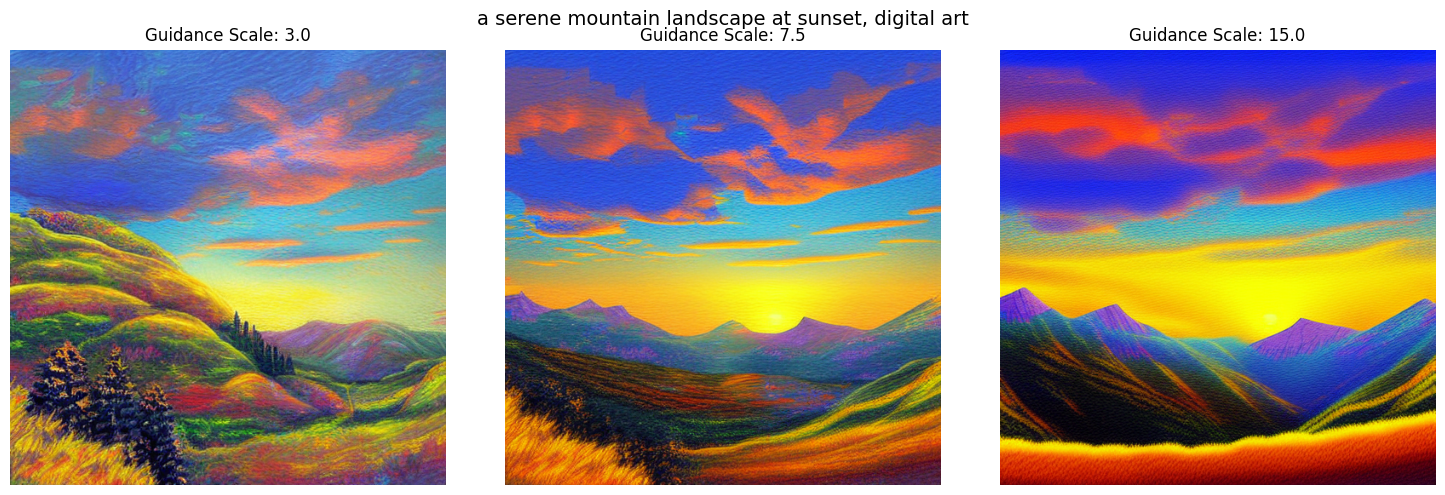


 Notice: Higher guidance = more saturated/defined features


In [19]:
prompt = "a serene mountain landscape at sunset, digital art"
guidance_values = [3.0, 7.5, 15.0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, guidance in enumerate(guidance_values):
    print(f"Generating with guidance_scale={guidance}...")
    img = generate_image(prompt, guidance_scale=guidance, seed=100)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Guidance Scale: {guidance}")

plt.suptitle(prompt, fontsize=14)
plt.tight_layout()
plt.show()

print("\n Notice: Higher guidance = more saturated/defined features")

### Parameter 2: `num_inference_steps` (Quality vs. Speed)

Number of denoising steps:
- **Low (20-25)**: Fast, good quality with DPM-Solver++
- **Medium (50)**: Standard quality
- **High (100+)**: Marginal improvements, much slower

Generating with 15 steps...


  0%|          | 0/15 [00:00<?, ?it/s]

Generating with 25 steps...


  0%|          | 0/25 [00:00<?, ?it/s]

Generating with 50 steps...


  0%|          | 0/50 [00:00<?, ?it/s]

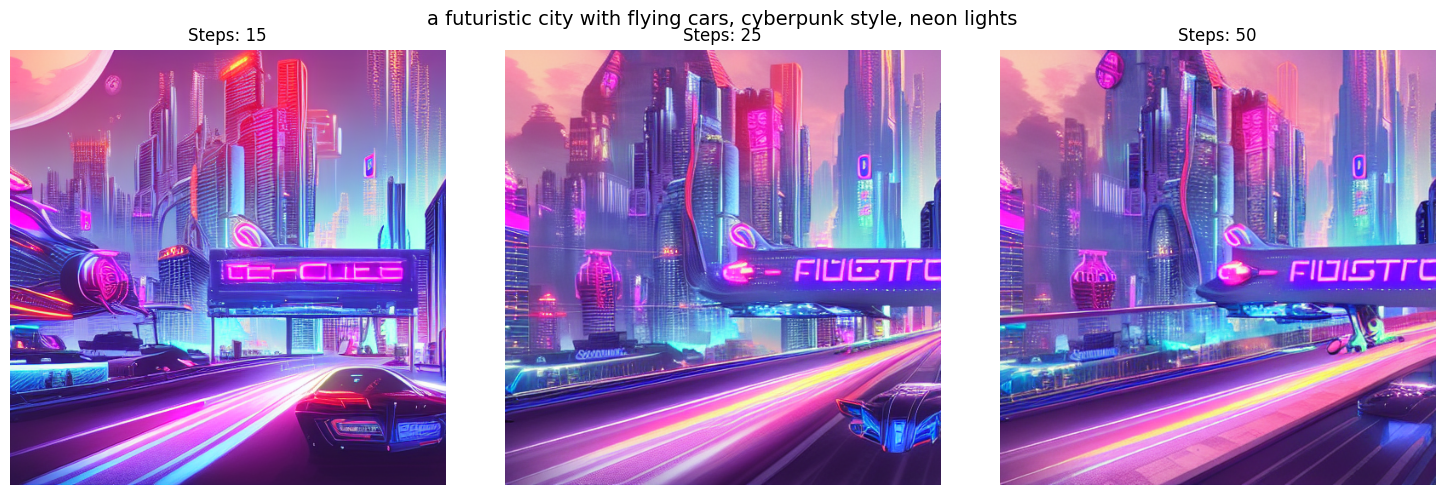


 Notice: 25 steps is often sufficient for good quality!


In [20]:
prompt = "a futuristic city with flying cars, cyberpunk style, neon lights"
step_values = [15, 25, 50]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, steps in enumerate(step_values):
    print(f"Generating with {steps} steps...")
    img = generate_image(prompt, num_inference_steps=steps, seed=200)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Steps: {steps}")

plt.suptitle(prompt, fontsize=14)
plt.tight_layout()
plt.show()

print("\n Notice: 25 steps is often sufficient for good quality!")

---

## 5️ Using Negative Prompts

Tell the model what you **DON'T** want in the image.

Prompt: a portrait of a dog, professional photography
Negative: blurry, low quality, distorted, cartoon, painting

Generating WITHOUT negative prompt...


  0%|          | 0/25 [00:00<?, ?it/s]

Generating WITH negative prompt...


  0%|          | 0/25 [00:00<?, ?it/s]

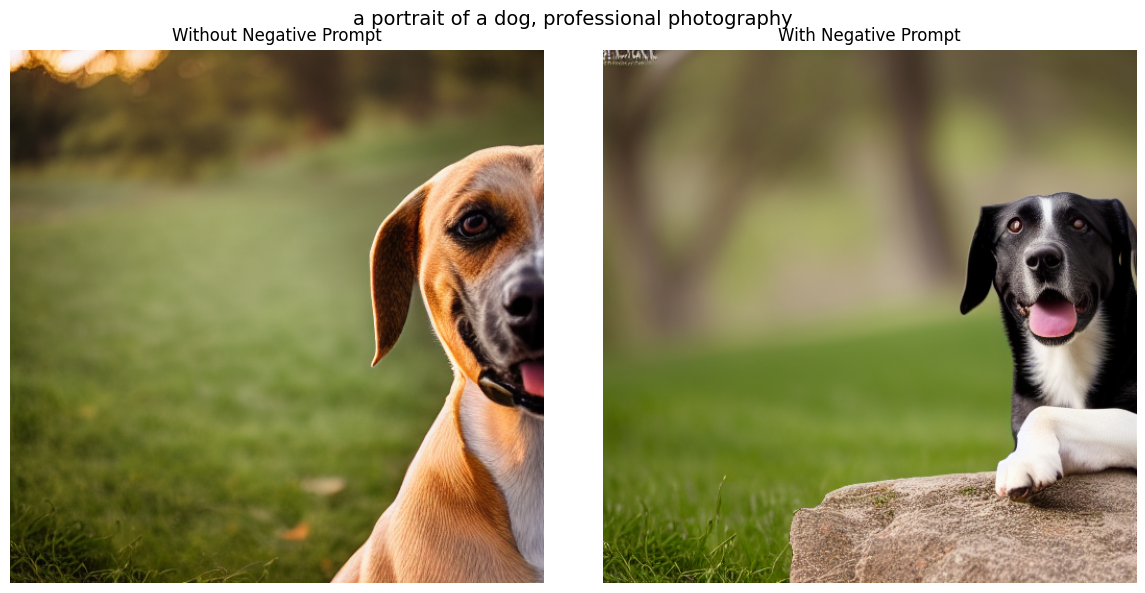


 Negative prompts help avoid unwanted artifacts!


In [21]:
prompt = "a portrait of a dog, professional photography"
negative_prompt = "blurry, low quality, distorted, cartoon, painting"

print(f"Prompt: {prompt}")
print(f"Negative: {negative_prompt}\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Without negative prompt
print("Generating WITHOUT negative prompt...")
img1 = generate_image(prompt, seed=300)
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title("Without Negative Prompt")

# With negative prompt
print("Generating WITH negative prompt...")
set_seed(300)
with torch.autocast(device):
    result = pipe(
        prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=25,
        guidance_scale=7.5,
    )
img2 = result.images[0]
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title("With Negative Prompt")

plt.suptitle(prompt, fontsize=14)
plt.tight_layout()
plt.show()

print("\n Negative prompts help avoid unwanted artifacts!")

---

## 6️Creative Prompt Examples

Try these prompts and experiment!

In [22]:
creative_prompts = [
    "an astronaut riding a horse on mars, cinematic lighting",
    "a steampunk robot playing chess, oil painting",
    "a cozy library inside a treehouse, warm lighting, fantasy art",
    "a bioluminescent jellyfish forest underwater, ethereal, 4k",
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, prompt in enumerate(creative_prompts):
    print(f"[{idx+1}/4] Generating: {prompt}")
    img = generate_image(prompt, seed=400+idx)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(prompt, fontsize=10, wrap=True)

    # Save each
    img.save(f"../outputs/creative_{idx+1}.png")

plt.tight_layout()
plt.show()

print("\n All images saved to outputs/")

Output hidden; open in https://colab.research.google.com to view.